In [4]:
# # Importing libraries
import mmcv
import random, string
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

In [5]:
# # Configuration file and Checkpoint file
# config_file = '../configs/mask_rcnn/mask_rcnn_r101_fpn_2x_coco.py'
config_file = '/workspace/configs/dent_configs.py'
checkpoint_file = '/workspace/models/dent_model.pth'

In [6]:
# Building the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

2021-03-17 03:54:09,572 - mmdet - INFO - Use load_from_torchvision loader
2021-03-17 03:54:09,837 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

missing keys in source state_dict: layer2.0.conv2.weight_diff, layer2.0.conv2.switch.weight, layer2.0.conv2.switch.bias, layer2.0.conv2.pre_context.weight, layer2.0.conv2.pre_context.bias, layer2.0.conv2.post_context.weight, layer2.0.conv2.post_context.bias, layer2.0.conv2.offset_s.weight, layer2.0.conv2.offset_s.bias, layer2.0.conv2.offset_l.weight, layer2.0.conv2.offset_l.bias, layer2.0.rfp_conv.weight, layer2.0.rfp_conv.bias, layer2.1.conv2.weight_diff, layer2.1.conv2.switch.weight, layer2.1.conv2.switch.bias, layer2.1.conv2.pre_context.weight, layer2.1.conv2.pre_context.bias, layer2.1.conv2.post_context.weight, layer2.1.conv2.post_context.bias, layer2.1.conv2.offset_s.weight, layer2.1.conv2.offset_s.bias, layer2.1.conv2.offset_l.weight, layer2.1.conv2.offse

Use load_from_local loader


In [7]:
# # Testing a single image
img = '/workspace/mmdetection/demo/MotionsCloud-01.jpg'
result = inference_detector(model, img)

/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


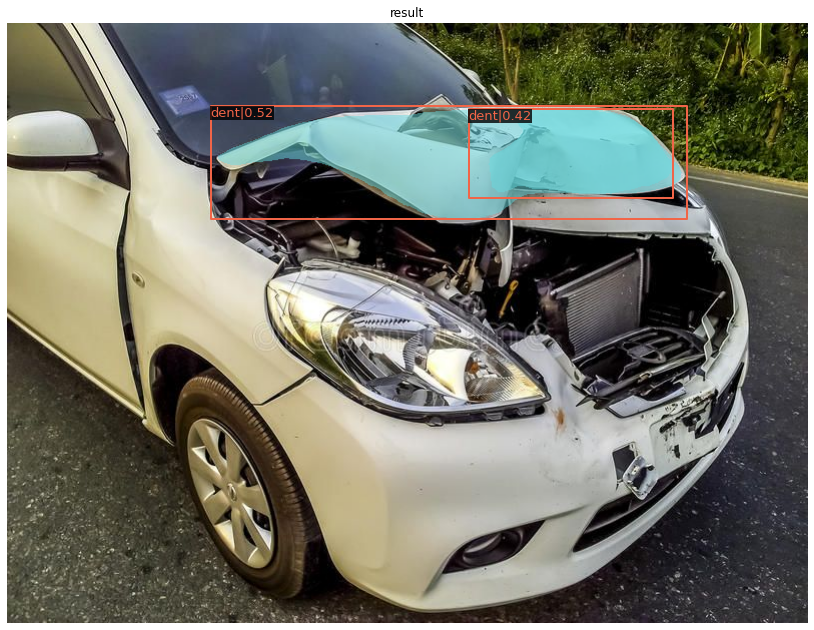

In [8]:
# # Showing the predicted image
show_result_pyplot(model, img, result)

### This part is to get the predicted_image, labels, scores & convert_masks for the process_.py <br/>
#### The logic asks for this json format
Output Format:<br />
        [pred_image, { <br />
            "labels": sample_labels_with_class_names,  <br />
            "scores": sample_filtered_score, <br />
            "mask": sample_segms_ndarray <br />
        }] <br />

In [9]:
# # Configuration & Libraries to get the requirement
import torch
import numpy as np
import matplotlib.pyplot as plt

score_threshold = 0.3
bbox_color = (72, 101, 241)
text_color = (72, 101, 241)

### - For predicted image

In [10]:
# # We are directly using the model to receive the image in numpy format
pred_image = model.show_result(
        img,
        result,
        score_thr=score_threshold,
        bbox_color=bbox_color,
        text_color=text_color)

In [11]:
pred_image.shape

(600, 800, 3)

In [12]:
height = pred_image.shape[0]
width = pred_image.shape[1]

### - For labels & scores

In [13]:
# # This code is extracted from 
# # https://mmdetection.readthedocs.io/en/latest/_modules/mmdet/models/detectors/base.html#BaseDetector.show_result
# # and I just used to get the stuffs that we need
if isinstance(result, tuple):
    bbox_result, segm_result = result
    if isinstance(segm_result, tuple):
        segm_result = segm_result[0]  # ms rcnn
else:
    bbox_result, segm_result = result, None
bboxes = np.vstack(bbox_result)
labels = [
    np.full(bbox.shape[0], i, dtype=np.int32)
    for i, bbox in enumerate(bbox_result)
]
labels = np.concatenate(labels)
class_name = model.CLASSES
scores = bboxes[:, -1]
# draw segmentation masks
segms = None
if segm_result is not None and len(labels) > 0:  # non empty
    segms = mmcv.concat_list(segm_result)
    if isinstance(segms[0], torch.Tensor):
        segms = torch.stack(segms, dim=0).detach().cpu().numpy()
    else:
        segms = np.stack(segms, axis=0)

In [14]:
# # Getting the scores below the threshold [easy way]
filtered_scores = scores[scores > score_threshold]
filtered_scores

array([0.5200569, 0.4243897], dtype=float32)

In [15]:
print(filtered_scores.shape)
print(type(filtered_scores))

(2,)
<class 'numpy.ndarray'>


In [16]:
# # Getting the scores and the labels with class names
sample_labels = []
sample_filtered_score = []
for i in range(len(scores)):
    if scores[i] > score_threshold:
        sample_labels.append(labels[i])
        sample_filtered_score.append(scores[i])
        
sample_labels_with_class_names = []
for i in range(len(sample_labels)):
    sample_labels_with_class_names.append(class_name[sample_labels[i]])

In [17]:
print(sample_labels_with_class_names)
print(sample_filtered_score)

['dent', 'dent']
[0.5200569, 0.4243897]


In [19]:
# # Keep in mind that we need in list so I will put some assert function.
assert type(sample_labels_with_class_names) == list
assert type(sample_filtered_score) == list

### - For convert masks

In [20]:
# # Here we get the masks
filtered_segms = []
total_number_of_labels = 0
for i in range(len(scores)):
    if scores[i] > score_threshold:
        filtered_segms.append(segms[i])
        total_number_of_labels += 1

In [21]:
filtered_segms_ndarray = np.array(filtered_segms)

In [22]:
print(type(filtered_segms_ndarray))
# print(type(filtered_segms_ndarray[0]))
print(filtered_segms_ndarray.dtype)

<class 'numpy.ndarray'>
bool


In [23]:
## Compatibility - Reshaping as per the requirement

In [24]:
# # Converting from boolean to integer (0, 1)
filtered_segms_ndarray = filtered_segms_ndarray.astype('uint8')

In [25]:
print(filtered_segms_ndarray.dtype)

uint8


In [26]:
filtered_segms_ndarray.shape

(2, 600, 800)

In [27]:
sample_segms_ndarray = filtered_segms_ndarray.reshape(total_number_of_labels, 1, height, width)

In [28]:
sample_segms_ndarray.shape

(2, 1, 600, 800)

In [29]:
assert sample_segms_ndarray.dtype == 'uint8'
assert type(sample_segms_ndarray) == np.ndarray

In [30]:
sample_segms_ndarray= [mask[0, :, :, None] for mask in sample_segms_ndarray]

In [31]:
sample_segms_ndarray

[array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]], dtype=uint8),
 array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
      

## Disection of the Masks
#### This is just a bonus to check whether the masks are legit or not

In [32]:
filtered_segms_ndarray

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

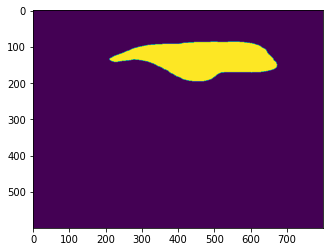

In [34]:
plt.imshow(filtered_segms_ndarray[0])